# Original Model

I choose a model from Internet and did'nt change any parameter, but `StandardScaler()`  `X`

change the learning rate to 0.001, change the epochs to 200

linear scaler is `Y = (Y - min(Y))/(max(Y) - min(Y))`

`batch_size` to 10

增加了一个dropout层，参数设为0.2，和keras中的相同

In [16]:
import pandas as pd
import numpy as np
import keras as kr
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv',index_col=0,header=0)
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv',index_col=0,header=0)
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv',index_col=0,header=0)
mddata = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [18]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return result

In [19]:
rawdataset = pd.merge(mddata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

Y = dataset.iloc[:, -1]
Y = np.array(Y, dtype = np.float32).reshape(-1,1)


X = dataset.iloc[:, 1:-1]
X = np.array(X, dtype = np.float32)

#Y= StandardScaler().fit_transform(Y)
#Y = (Y - min(Y))/(max(Y) - min(Y))
Y = Y/max(Y)
X= StandardScaler().fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 50, input_dim = X.shape[1]))
model.add(Activation("sigmoid"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(units = 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                47300     
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 47,351
Trainable params: 47,351
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 10,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Test loss: 0.01355871930718422
Test accuracy: 0.0
Neural Network RMS 0.11644191387633672


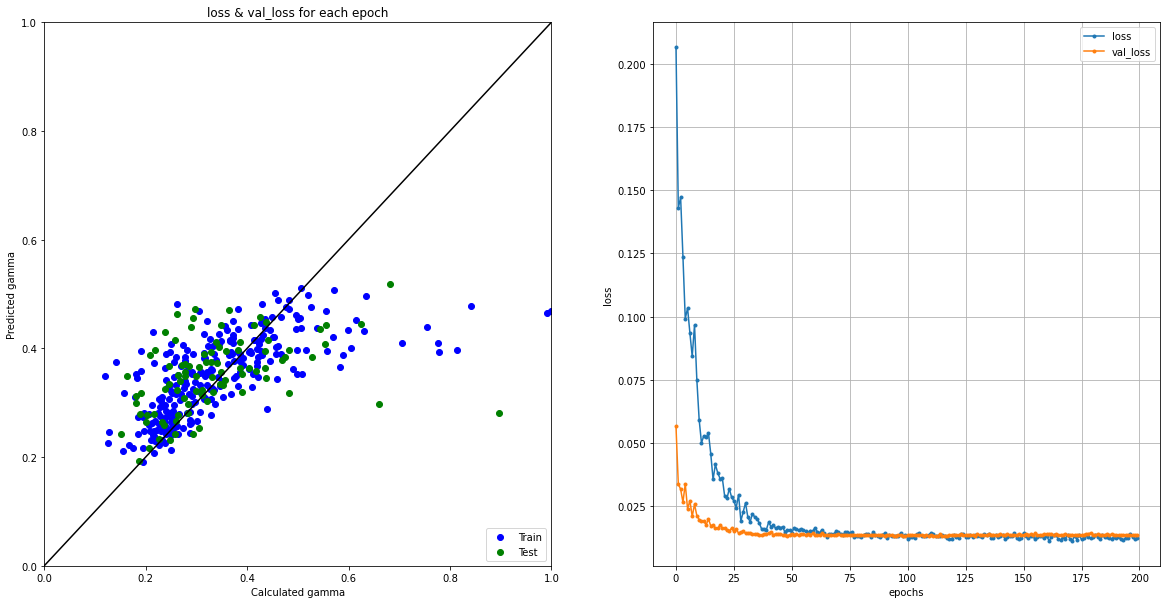

In [23]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
ax1.scatter(y_test, model.predict(X_test),c='green', label = 'Test', alpha = None)
ax1.plot([-2.5,2.5],[-2.5,2.5],c = 'k')
ax1.legend(loc = 4)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)

ax2 = fig.add_subplot(122)
ax1.set_title('loss & val_loss for each epoch')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.plot(range(epochs), loss, marker = '.', label = 'loss')
ax2.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best')
ax2.grid()

plt.show()

## Conclusion

the loss is not get bigger, although the overfit

since `batch_zize` is less, the times of train is more, it time to add the dropout layer

### it is strange that the large gamma is not affected by the small, maybe the 去除了相同元素的原因

真有意思，刚说了大gamma不受影响，现在就出来

去掉大于归一化后大于0.5的样本，看看有什么发现

明显是使用了drop之后产生不平衡的问题